# 03. Build a Time Series of SWOT Simulated Data

#### **Import libraries**
In additional to libraries from the first tutorial, also import libraries needed to submit CMR requests.

In [9]:
import xarray as xr
import numpy as np
from IPython.display import display, JSON
from datetime import datetime, timedelta, time
import os 

# highlight the harmony-py library
from harmony import BBox, Client, Collection, Request, Environment, LinkType 

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

%matplotlib inline

# Additional libraries compared to the first tutorial.
from urllib import request
import json
import requests
import sys
import shutil
from urllib.parse import urlencode

#### **Let's start up the client from the harmony-py library and define the CMR url.**

In [2]:
harmony_client = Client(env=Environment.PROD)
cmr_root = 'cmr.earthdata.nasa.gov'

### **KaRIn CalVal**

#### **Search by cycle and pass using CMR**
CMR Search: Number of item returned is limited to 10,000 (or 1 million if targeting collections)
https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html#paging-details

In [3]:
provider = 'POCLOUD'
short_name = 'SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_CALVAL_V1'

target_cycle = list(range(1,101))
target_pass = [2, 17]
page_size = 2000

granuleIDs = []
params_without_cycle = [
    ('page_size', page_size),
    ('sort_key', "-start_date"),
    ('provider', provider),
    ('ShortName', short_name),
    #('collection_concept_id', ccid), 
    #('token', token),
    #('cycle', targetcycle), # can only specify one cycle at a time when specifying passes 
    ('passes[0][pass]', target_pass[0]), 
    ('passes[1][pass]', target_pass[1]),
]

for v in target_cycle:
    params = [("cycle[]", v)]
    params.extend(params_without_cycle)
    # print(params)
    query = urlencode(params)
    cmr_url = f"https://{cmr_root}/search/granules.umm_json?{query}"
    # print(cmr_url)
    response = requests.get(cmr_url)
    response_body = response.json()
    
    for itm in response_body['items']:
        granuleIDs.append(itm['meta']['concept-id'])

len(granuleIDs) # Note the 200-granule limit

200

#### **Then perform a spatial subset and download using Harmony**
On the back end, the subsetting part of Harmony is powered by L2SS-py

In [4]:
# collection = Collection(id=ccid)
collection = Collection(id=short_name)

# start_day = datetime(2015,4,15,0,0,0)
# end_day = datetime(2015,4,17,0,0,0)

request = Request(
    collection=collection,
    spatial=BBox(-140, 20, -100, 50), # [20-50N], [-140W, -100W] CA Current
    #variables=[],
    # temporal={
    #     'start': start_day,
    #     'stop': end_day # goal: try up to 21 days at least,
    #},
    granule_id=granuleIDs,
)

request.is_valid()

True

In [5]:
print(harmony_client.request_as_curl(request))
job_id = harmony_client.submit(request)
print(f'Job ID: {job_id}')

curl -X GET -H 'Accept: */*' -H 'Accept-Encoding: gzip, deflate, br' -H 'Connection: keep-alive' -H 'Cookie: urs_user_already_logged=yes; token=*****; _urs-gui_session=65ab2b179a8399c940c2958f7cc9e9c6' -H 'User-Agent: CPython/3.9.10 python-requests/2.27.1 Linux/5.4.156-83.273.amzn2.x86_64 harmony-py/0.4.1' 'https://harmony.earthdata.nasa.gov/SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_CALVAL_V1/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?forceAsync=true&subset=lat%2820%3A50%29&subset=lon%28-140%3A-100%29&granuleId=G2163075767-POCLOUD&granuleId=G2163075695-POCLOUD&granuleId=G2163075972-POCLOUD&granuleId=G2163075790-POCLOUD&granuleId=G2163075917-POCLOUD&granuleId=G2163075788-POCLOUD&granuleId=G2163075734-POCLOUD&granuleId=G2163075869-POCLOUD&granuleId=G2163075832-POCLOUD&granuleId=G2163077159-POCLOUD&granuleId=G2163076040-POCLOUD&granuleId=G2163075929-POCLOUD&granuleId=G2163077157-POCLOUD&granuleId=G2163075707-POCLOUD&granuleId=G2163079357-POCLOUD&granuleId=G2163079356-POCLOUD&granu

In [6]:
harmony_client.status(job_id)

{'status': 'running',
 'message': 'The job is being processed',
 'progress': 0,
 'created_at': datetime.datetime(2022, 3, 16, 0, 4, 15, 487000, tzinfo=tzlocal()),
 'updated_at': datetime.datetime(2022, 3, 16, 0, 4, 15, 521000, tzinfo=tzlocal()),
 'created_at_local': '2022-03-16T00:04:15+00:00',
 'updated_at_local': '2022-03-16T00:04:15+00:00',
 'request': 'https://harmony.earthdata.nasa.gov/SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_CALVAL_V1/ogc-api-coverages/1.0.0/collections/all/coverage/rangeset?forceAsync=true&subset=lat(20%3A50)&subset=lon(-140%3A-100)&granuleId=G2163075767-POCLOUD&granuleId=G2163075695-POCLOUD&granuleId=G2163075972-POCLOUD&granuleId=G2163075790-POCLOUD&granuleId=G2163075917-POCLOUD&granuleId=G2163075788-POCLOUD&granuleId=G2163075734-POCLOUD&granuleId=G2163075869-POCLOUD&granuleId=G2163075832-POCLOUD&granuleId=G2163077159-POCLOUD&granuleId=G2163076040-POCLOUD&granuleId=G2163075929-POCLOUD&granuleId=G2163077157-POCLOUD&granuleId=G2163075707-POCLOUD&granuleId=G2163079357-P

In [7]:
# results = harmony_client.result_urls(job_id, link_type=LinkType.s3)
# urls = list(results)
# print(urls)

In [10]:
# create a new folder to put the subsetted data in
os.makedirs("swot_ocean",exist_ok = True)

In [11]:
futures = harmony_client.download_all(job_id, directory='./swot_ocean', overwrite=True)
file_names = [f.result() for f in futures]
sorted(file_names)

['./swot_ocean/SWOT_L2_LR_SSH_Expert_001_002_20140412T125105_20140412T134211_DG10_01_subsetted.nc4',
 './swot_ocean/SWOT_L2_LR_SSH_Expert_001_017_20140413T013731_20140413T022836_DG10_01_subsetted.nc4',
 './swot_ocean/SWOT_L2_LR_SSH_Expert_002_002_20140413T124143_20140413T133248_DG10_01_subsetted.nc4',
 './swot_ocean/SWOT_L2_LR_SSH_Expert_002_017_20140414T012808_20140414T021913_DG10_01_subsetted.nc4',
 './swot_ocean/SWOT_L2_LR_SSH_Expert_003_002_20140414T123220_20140414T132325_DG10_01_subsetted.nc4',
 './swot_ocean/SWOT_L2_LR_SSH_Expert_003_017_20140415T011845_20140415T020951_DG10_01_subsetted.nc4',
 './swot_ocean/SWOT_L2_LR_SSH_Expert_004_002_20140415T122257_20140415T131403_DG10_01_subsetted.nc4',
 './swot_ocean/SWOT_L2_LR_SSH_Expert_004_017_20140416T010922_20140416T020028_DG10_01_subsetted.nc4',
 './swot_ocean/SWOT_L2_LR_SSH_Expert_005_002_20140416T121334_20140416T130440_DG10_01_subsetted.nc4',
 './swot_ocean/SWOT_L2_LR_SSH_Expert_005_017_20140417T005959_20140417T015105_DG10_01_subset

In [12]:
ds = xr.open_mfdataset(sorted(file_names),combine='nested',concat_dim='num_lines')
ds

<xarray.Dataset>
Dimensions:                                (num_lines: 345000, num_pixels: 71,
                                            num_sides: 2)
Coordinates:
    latitude                               (num_lines, num_pixels) float64 dask.array<chunksize=(1725, 71), meta=np.ndarray>
    longitude                              (num_lines, num_pixels) float64 dask.array<chunksize=(1725, 71), meta=np.ndarray>
    latitude_nadir                         (num_lines) float64 dask.array<chunksize=(1725,), meta=np.ndarray>
    longitude_nadir                        (num_lines) float64 dask.array<chunksize=(1725,), meta=np.ndarray>
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/91)
    time                                   (num_lines) datetime64[ns] dask.array<chunksize=(1725,), meta=np.ndarray>
    time_tai                               (num_lines) datetime64[ns] dask.array<chunksize=(1725,), meta=np.ndarray>
    ssh_karin                              (num_lines, num_pixels) float64 dask.array<chunksize=(1725, 71), meta=np.ndarray>
    ssh_karin_uncert                       (num_lines, num_pixels) float32 dask.array<chunksize=(1725, 71), meta=np.ndarray>
    ssha_karin                             (num_lines, num_pixels) float64 dask.array<chunksize=(1725, 71), meta=np.ndarray>
    ssh_karin_2                            (num_lines, num_pixels) float64 dask.array<chunksize=(1725, 71), meta=np.ndarray>
    ...                                     ...
    simulated_error_karin                  (num_lines, num_pixels) float64 dask.array<chunksize=(1725, 71), meta=np.ndarray>
    simulated_error_timing                 (num_lines, num_pixels) float64 dask.array<chunksize=(1725, 71), meta=np.ndarray>
    simulated_error_roll                   (num_lines, num_pixels) float64 dask.array<chunksize=(1725, 71), meta=np.ndarray>
    simulated_error_phase                  (num_lines, num_pixels) float64 dask.array<chunksize=(1725, 71), meta=np.ndarray>
    simulated_error_baseline_dilation      (num_lines, num_pixels) float64 dask.array<chunksize=(1725, 71), meta=np.ndarray>
    simulated_error_orbital                (num_lines, num_pixels) float64 dask.array<chunksize=(1725, 71), meta=np.ndarray>
Attributes: (12/33)
    Conventions:                CF-1.7
    title:                      Level 2 Low Rate Sea Surface Height Data Prod...
    institution:                CNES/JPL
    source:                     Simulate product
    history:                    2021-09-10 10:21:42Z : Creation\n2022-03-16 0...
    platform:                   SWOT
    ...                         ...
    right_last_latitude:        -78.29215289609066
    wavelength:                 0.008385803020979
    orbit_solution:             POE
    ellipsoid_semi_major_axis:  6378137.0
    ellipsoid_flattening:       0.003352810664781205
    history_json:               [{"date_time": "2022-03-16T00:15:31.483536+00...

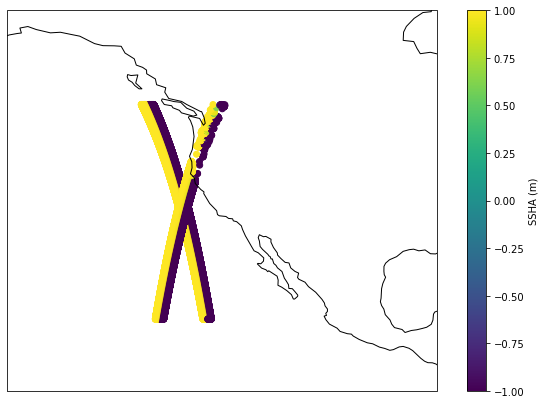

In [13]:
# Plot only a pair of passes at a time
i_time = np.arange(0,1725*2)+1725*90

fig = plt.figure(figsize=[11,7]) 
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-150, -90, 10, 60])
plt.scatter(ds.longitude[i_time,:], ds.latitude[i_time,:], lw=1, c=ds.ssha_karin[i_time,:])
plt.colorbar(label='SSHA (m)')
plt.clim(-1,1)
plt.show()

In [14]:
ds.ssha_karin

<xarray.DataArray 'ssha_karin' (num_lines: 345000, num_pixels: 71)>
dask.array<concatenate, shape=(345000, 71), dtype=float64, chunksize=(1725, 71), chunktype=numpy.ndarray>
Coordinates:
    latitude         (num_lines, num_pixels) float64 dask.array<chunksize=(1725, 71), meta=np.ndarray>
    longitude        (num_lines, num_pixels) float64 dask.array<chunksize=(1725, 71), meta=np.ndarray>
    latitude_nadir   (num_lines) float64 dask.array<chunksize=(1725,), meta=np.ndarray>
    longitude_nadir  (num_lines) float64 dask.array<chunksize=(1725,), meta=np.ndarray>
Dimensions without coordinates: num_lines, num_pixels
Attributes:
    long_name:  sea surface height anomaly
    units:      m
    valid_min:  -1000000
    valid_max:  1000000
    comment:    Sea surface height anomaly from the KaRIn measurement = ssh_k...